In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df_maxim = pd.read_csv("outputs/generation_maxim.csv")
df_speech = pd.read_csv("outputs/generation_speech_act.csv")

print(f"Maxim samples: {len(df_maxim)}")
print(f"Speech act samples: {len(df_speech)}")

Maxim samples: 100
Speech act samples: 100


In [25]:
df_maxim['gt_maxim_quantity'].unique()

array(['Flouted', 'Observed'], dtype=object)

In [11]:
# ========== MAXIM ANALYSIS ==========
print("=" * 60)
print("MAXIM ANALYSIS")
print("=" * 60)

maxim_types = ["quality", "quantity", "relevance", "manner"]

# F1, Precision, Recall for each maxim
print("\n--- Per-Maxim Metrics ---")
metrics_data = []

for maxim in maxim_types:
    pred_col = f"pred_maxim_{maxim}"
    gt_col = f"gt_maxim_{maxim}"
    
    y_true = df_maxim[gt_col].fillna("").str.lower().str.strip()
    y_pred = df_maxim[pred_col].fillna("").str.lower().str.strip()
    
    # Filter to valid rows only
    valid_mask = (y_true.isin(["observed", "flouted"])) & (y_pred.isin(["observed", "flouted"]))
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    precision = precision_score(y_true, y_pred, pos_label="flouted", zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label="flouted", zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label="flouted", zero_division=0)
    accuracy = (y_true == y_pred).mean()
    
    metrics_data.append({
        "maxim": maxim,
        "valid_samples": valid_mask.sum(),
        "accuracy": accuracy,
        "precision_flouted": precision,
        "recall_flouted": recall,
        "f1_flouted": f1,
    })
    
    print(f"\n{maxim.upper()} (n={valid_mask.sum()}):")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (Flouted): {precision:.4f}")
    print(f"  Recall (Flouted): {recall:.4f}")
    print(f"  F1 (Flouted): {f1:.4f}")

metrics_df = pd.DataFrame(metrics_data)
print("\n--- Summary Table ---")
print(metrics_df.to_string(index=False))

MAXIM ANALYSIS

--- Per-Maxim Metrics ---

QUALITY (n=95):
  Accuracy: 0.8000
  Precision (Flouted): 0.2857
  Recall (Flouted): 0.6000
  F1 (Flouted): 0.3871

QUANTITY (n=99):
  Accuracy: 0.3838
  Precision (Flouted): 0.6471
  Recall (Flouted): 0.1667
  F1 (Flouted): 0.2651

RELEVANCE (n=100):
  Accuracy: 0.8200
  Precision (Flouted): 0.0000
  Recall (Flouted): 0.0000
  F1 (Flouted): 0.0000

MANNER (n=100):
  Accuracy: 0.7000
  Precision (Flouted): 0.3043
  Recall (Flouted): 0.3333
  F1 (Flouted): 0.3182

--- Summary Table ---
    maxim  valid_samples  accuracy  precision_flouted  recall_flouted  f1_flouted
  quality             95  0.800000           0.285714        0.600000    0.387097
 quantity             99  0.383838           0.647059        0.166667    0.265060
relevance            100  0.820000           0.000000        0.000000    0.000000
   manner            100  0.700000           0.304348        0.333333    0.318182


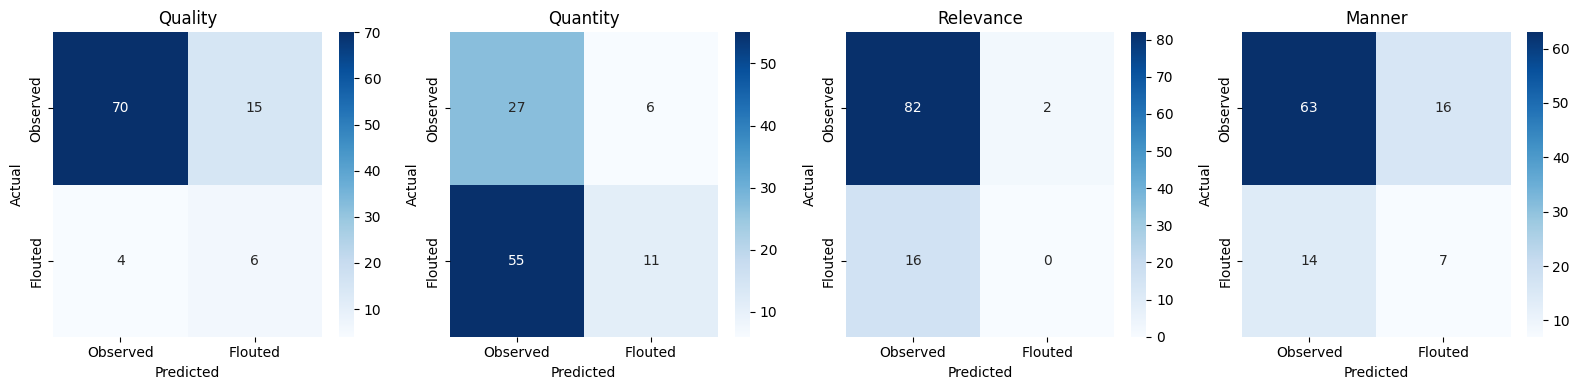

In [16]:
# Confusion matrices for each maxim
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, maxim in enumerate(maxim_types):
    pred_col = f"pred_maxim_{maxim}"
    gt_col = f"gt_maxim_{maxim}"
    
    y_true = df_maxim[gt_col].fillna("").str.lower().str.strip()
    y_pred = df_maxim[pred_col].fillna("").str.lower().str.strip()
    
    # Filter to valid rows only
    valid_mask = (y_true.isin(["observed", "flouted"])) & (y_pred.isin(["observed", "flouted"]))
    y_true = y_true[valid_mask].values
    y_pred = y_pred[valid_mask].values
    
    cm = confusion_matrix(y_true, y_pred, labels=["observed", "flouted"])
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i],
                xticklabels=["Observed", "Flouted"],
                yticklabels=["Observed", "Flouted"])
    axes[i].set_title(f"{maxim.capitalize()}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [4]:
# Pattern analysis: What combinations does the model get wrong?
print("\n--- Error Pattern Analysis ---")

# Create error pattern columns
df_maxim["error_pattern"] = ""
for maxim in maxim_types:
    df_maxim[f"err_{maxim}"] = df_maxim[f"compare_maxim_{maxim}"] == 0

# Count samples with N errors
error_counts = df_maxim[[f"err_{m}" for m in maxim_types]].sum(axis=1)
print("\nErrors per sample distribution:")
print(error_counts.value_counts().sort_index())

# Which maxims are most often wrong together?
print("\nCo-occurrence of errors (when both are wrong):")
for i, m1 in enumerate(maxim_types):
    for m2 in maxim_types[i+1:]:
        both_wrong = (df_maxim[f"err_{m1}"] & df_maxim[f"err_{m2}"]).sum()
        print(f"  {m1} + {m2}: {both_wrong}")


--- Error Pattern Analysis ---

Errors per sample distribution:
0    17
1    49
2    19
3    13
4     2
Name: count, dtype: int64

Co-occurrence of errors (when both are wrong):
  quality + quantity: 13
  quality + relevance: 7
  quality + manner: 11
  quantity + relevance: 12
  quantity + manner: 16
  relevance + manner: 11


In [5]:
# Direction of errors: Does model over-predict Observed or Flouted?
print("\n--- Error Direction ---")
for maxim in maxim_types:
    pred_col = f"pred_maxim_{maxim}"
    gt_col = f"gt_maxim_{maxim}"

    y_true = df_maxim[gt_col].str.lower().str.strip()
    y_pred = df_maxim[pred_col].str.lower().str.strip()

    false_observed = ((y_pred == "observed") & (y_true == "flouted")).sum()
    false_flouted = ((y_pred == "flouted") & (y_true == "observed")).sum()

    print(f"{maxim}: Predicted Observed (actual Flouted): {false_observed}, Predicted Flouted (actual Observed): {false_flouted}")


--- Error Direction ---
quality: Predicted Observed (actual Flouted): 4, Predicted Flouted (actual Observed): 15
quantity: Predicted Observed (actual Flouted): 55, Predicted Flouted (actual Observed): 6
relevance: Predicted Observed (actual Flouted): 16, Predicted Flouted (actual Observed): 2
manner: Predicted Observed (actual Flouted): 14, Predicted Flouted (actual Observed): 16


In [6]:
# ========== SPEECH ACT ANALYSIS ==========
print("\n" + "=" * 60)
print("SPEECH ACT ANALYSIS")
print("=" * 60)

print(f"\nOverall metrics:")
print(f"  Mean Precision: {df_speech['speech_act_precision'].mean():.4f}")
print(f"  Mean Recall: {df_speech['speech_act_recall'].mean():.4f}")
print(f"  Mean F1: {df_speech['speech_act_f1'].mean():.4f}")


SPEECH ACT ANALYSIS

Overall metrics:
  Mean Precision: 0.5907
  Mean Recall: 0.6167
  Mean F1: 0.5748


In [7]:
# Distribution of predicted vs actual speech acts
def get_all_labels(series):
    all_labels = []
    for val in series.dropna():
        labels = [l.strip().lower() for l in str(val).split(",") if l.strip()]
        all_labels.extend(labels)
    return pd.Series(all_labels).value_counts()

pred_dist = get_all_labels(df_speech["pred_speech_act"])
gt_dist = get_all_labels(df_speech["gt_speech_act"])

# Combine into comparison df
all_labels = set(pred_dist.index) | set(gt_dist.index)
dist_comparison = pd.DataFrame({
    "label": list(all_labels),
    "predicted_count": [pred_dist.get(l, 0) for l in all_labels],
    "actual_count": [gt_dist.get(l, 0) for l in all_labels],
})
dist_comparison["diff"] = dist_comparison["predicted_count"] - dist_comparison["actual_count"]
dist_comparison = dist_comparison.sort_values("actual_count", ascending=False)

print("\n--- Label Distribution Comparison ---")
print(dist_comparison.to_string(index=False))


--- Label Distribution Comparison ---
                                                  label  predicted_count  actual_count  diff
                                                express               61            63    -2
                                               complain               47            44     3
                                               question               44            39     5
                                                 assert               60            37    23
                                                request               20            37   -17
                                                suggest               10            10     0
                                                 praise                3             2     1
                                    it's chilly in here                0             1    -1
                                              isn't it?                0             1    -1
                               

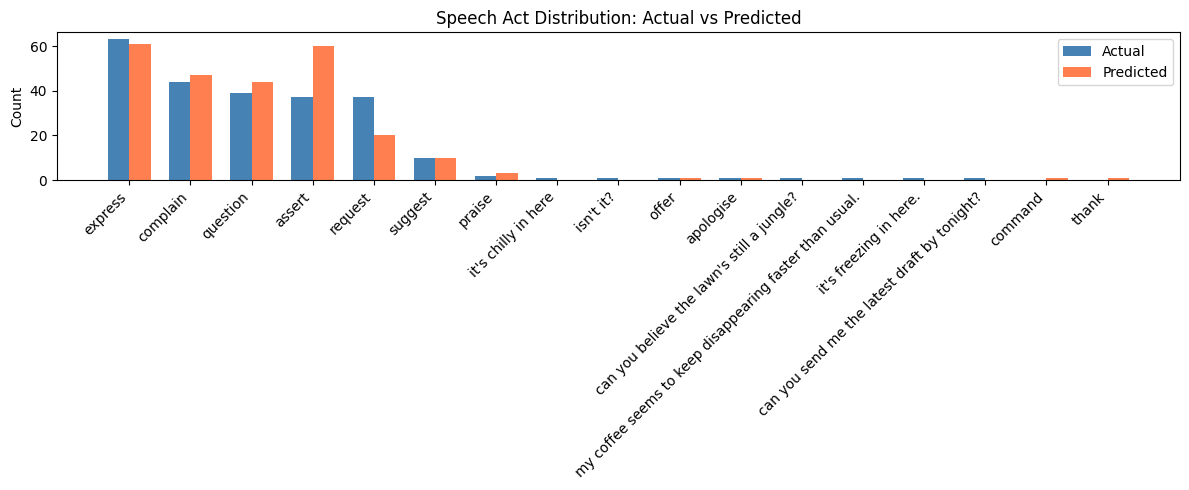

In [8]:
# Visualize distribution
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(dist_comparison))
width = 0.35

ax.bar(x - width/2, dist_comparison["actual_count"], width, label="Actual", color="steelblue")
ax.bar(x + width/2, dist_comparison["predicted_count"], width, label="Predicted", color="coral")
ax.set_xticks(x)
ax.set_xticklabels(dist_comparison["label"], rotation=45, ha="right")
ax.legend()
ax.set_ylabel("Count")
ax.set_title("Speech Act Distribution: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [9]:
# Per-label precision/recall
print("\n--- Per-Label Analysis ---")

def compute_per_label_metrics(df):
    # Get all unique labels
    all_labels = set()
    for col in ["pred_speech_act", "gt_speech_act"]:
        for val in df[col].dropna():
            for l in str(val).split(","):
                all_labels.add(l.strip().lower())

    metrics = []
    for label in sorted(all_labels):
        # For each sample, check if label is in pred and gt
        in_pred = df["pred_speech_act"].fillna("").str.lower().str.contains(rf"\b{label}\b", regex=True)
        in_gt = df["gt_speech_act"].fillna("").str.lower().str.contains(rf"\b{label}\b", regex=True)

        tp = (in_pred & in_gt).sum()
        fp = (in_pred & ~in_gt).sum()
        fn = (~in_pred & in_gt).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        metrics.append({
            "label": label,
            "support": in_gt.sum(),
            "predicted": in_pred.sum(),
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        })

    return pd.DataFrame(metrics).sort_values("support", ascending=False)

label_metrics = compute_per_label_metrics(df_speech)
print(label_metrics.to_string(index=False))


--- Per-Label Analysis ---
                                                  label  support  predicted  TP  FP  FN  precision   recall       f1
                                                express       63         61  40  21  23   0.655738 0.634921 0.645161
                                               complain       44         47  32  15  12   0.680851 0.727273 0.703297
                                               question       39         44  31  13   8   0.704545 0.794872 0.746988
                                                request       37         20  15   5  22   0.750000 0.405405 0.526316
                                                 assert       37         60  22  38  15   0.366667 0.594595 0.453608
                                                suggest       10         10   4   6   6   0.400000 0.400000 0.400000
                                                 praise        2          3   1   2   1   0.333333 0.500000 0.400000
                                    

In [10]:
# What labels does the model miss most often (low recall)?
print("\n--- Labels the model misses (low recall, support >= 5) ---")
low_recall = label_metrics[(label_metrics["recall"] < 0.5) & (label_metrics["support"] >= 5)]
print(low_recall[["label", "support", "recall", "FN"]].to_string(index=False))

# What labels does the model over-predict (low precision)?
print("\n--- Labels the model over-predicts (low precision, predicted >= 5) ---")
low_precision = label_metrics[(label_metrics["precision"] < 0.5) & (label_metrics["predicted"] >= 5)]
print(low_precision[["label", "predicted", "precision", "FP"]].to_string(index=False))


--- Labels the model misses (low recall, support >= 5) ---
  label  support   recall  FN
request       37 0.405405  22
suggest       10 0.400000   6

--- Labels the model over-predicts (low precision, predicted >= 5) ---
  label  predicted  precision  FP
 assert         60   0.366667  38
suggest         10   0.400000   6


In [19]:
# Examples where model missed Request (FN: actual has Request, predicted doesn't)
print("=" * 70)
print("MISSED REQUESTS (actual=Request, predicted≠Request)")
print("=" * 70)

for idx, row in df_speech.iterrows():
    gt = str(row["gt_speech_act"]).lower()
    pred = str(row["pred_speech_act"]).lower()
    
    if "request" in gt and "request" not in pred:
        print(f"\n[{idx}] Speech: {row['speech'][:200]}")
        print(f"    GT: {row['gt_speech_act']}")
        print(f"    Pred: {row['pred_speech_act']}")
        if idx > 50:  # limit output
            print("\n... (showing first ~10)")
            break

MISSED REQUESTS (actual=Request, predicted≠Request)

[3] Speech: <speech>I'm juggling too many tasks and can't seem to catch a break. Any thoughts?</speech>
    GT: Assert, Request
    Pred: Assert, Complain, Express, Question

[4] Speech: <speech>I'm thinking of surprising my partner with something special, but I'm unsure what would be more meaningful.</speech>
    GT: Express, Request
    Pred: Express, Question

[6] Speech: <speech>I'm curious if taking on that project is a good move, or if it's just biting off more than I can chew.</speech>
    GT: Assert, Question, Request
    Pred: Question, Express

[7] Speech: <speech>Can you believe my phone just died again?</speech>
    GT: Express, Complain, Request
    Pred: Question, Assert, Complain, Express

[11] Speech: <speech>"Feels like every meeting is just a repeat of the last. How can we make them more productive?"</speech>
    GT: Express, Complain, Request
    Pred: Express, Complain, Question, Assert

[14] Speech: <speech>I'm n

In [21]:
# Examples where model over-predicted Assert (FP: predicted Assert, actual doesn't have it)
print("=" * 70)
print("FALSE ASSERT (predicted=Assert, actual≠Assert)")
print("=" * 70)

for idx, row in df_speech.iterrows():
    gt = str(row["gt_speech_act"]).lower()
    pred = str(row["pred_speech_act"]).lower()
    
    if "assert" in pred and "assert" not in gt:
        print(f"\n[{idx}] Speech: {row['speech'][:200]}")
        print(f"    GT: {row['gt_speech_act']}")
        print(f"    Pred: {row['pred_speech_act']}")
        if idx > 50:
            print("\n... (showing first ~50)")
            break

FALSE ASSERT (predicted=Assert, actual≠Assert)

[2] Speech: <speech>I can't believe I've got another late-night email from the boss. Seriously, do they expect us to be on call 24/7?</speech>
    GT: Complain
    Pred: Assert, Question, Complain, Express

[7] Speech: <speech>Can you believe my phone just died again?</speech>
    GT: Express, Complain, Request
    Pred: Question, Assert, Complain, Express

[9] Speech: <speech>"Sure, I dropped my phone in the lake, but who needs pictures these days?"</speech>
    GT: Express, Complain
    Pred: Assert, Question, Complain

[10] Speech: <speech>"Hey, I guess the weather isn't as bad as last time."</speech>
    GT: Suggest
    Pred: Assert

[11] Speech: <speech>"Feels like every meeting is just a repeat of the last. How can we make them more productive?"</speech>
    GT: Express, Complain, Request
    Pred: Express, Complain, Question, Assert

[16] Speech: <speech>Thinking of trying something different for Saturday, but can't decide between 